# Run Expectancy

Ported from **Analyzing Baseball Data with R**, by Marchi, Albert and Baumer, Chapter 5

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.options.display.max_columns = 999

In [2]:
fields = pd.read_csv('../data/fields.csv', index_col=0)
data2016 = pd.read_csv('../data/all2016.csv', names=fields.Header)

/Users/cfonnesbeck/anaconda3/envs/baseball/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (64,65,84,85) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Runs scored in the remainder of the inning

In [3]:
data2016['RUNS'] = data2016.AWAY_SCORE_CT + data2016.HOME_SCORE_CT
data2016['HALF_INNING'] = (data2016.GAME_ID 
                            + data2016.INN_CT.astype(str) 
                            + data2016.BAT_HOME_ID.astype(str))
data2016['RUNS_SCORED'] = ((data2016.BAT_DEST_ID > 3).astype(int) 
                            + (data2016.RUN1_DEST_ID > 3).astype(int)
                            + (data2016.RUN2_DEST_ID > 3).astype(int)
                            + (data2016.RUN3_DEST_ID > 3).astype(int))

In [4]:
half_innings = data2016.groupby('HALF_INNING').agg(outs_inning=('EVENT_OUTS_CT',sum),
                                                    runs_inning=('RUNS_SCORED',sum),
                                                    runs_start=('RUNS',min))
half_innings['MAX_RUNS'] = half_innings.runs_inning + half_innings.runs_start

The runs from the event to the end of the inning is the difference between the total runs scored in the inning and the runs scored up until the event.

In [5]:
data2016 = data2016.join(half_innings, on='HALF_INNING', how='inner')
data2016['RUNS_ROI'] = data2016.MAX_RUNS - data2016.RUNS

In [6]:
assert not data2016.loc[data2016.MAX_RUNS < data2016.RUNS, ['HALF_INNING', 'RUNS_SCORED', 'RUNS', 'MAX_RUNS']].values

<ipython-input-6-9fc932a53728>:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  assert not data2016.loc[data2016.MAX_RUNS < data2016.RUNS, ['HALF_INNING', 'RUNS_SCORED', 'RUNS', 'MAX_RUNS']].values


## Run expectancy matrix

Create string variable for base occupancy state.

In [7]:
data2016['STATE'] = ((~data2016.BASE1_RUN_ID.isnull()).astype(int).astype(str)
                    + (~data2016.BASE2_RUN_ID.isnull()).astype(int).astype(str)
                    + (~data2016.BASE3_RUN_ID.isnull()).astype(int).astype(str)
                    + data2016.OUTS_CT.astype(str))

data2016['STATE'].unique()

array(['0000', '0100', '0011', '0012', '1002', '0001', '0002', '1001',
       '1000', '1100', '1101', '0111', '1011', '1102', '0110', '1111',
       '1012', '1112', '0102', '1010', '0101', '0112', '1110', '0010'],
      dtype=object)

Create indicators for base occupancy following the play.

In [8]:
data2016['NRUNNER1'] = ((data2016.RUN1_DEST_ID==1) | (data2016.BAT_DEST_ID==1)).astype(int)
data2016['NRUNNER2'] = ((data2016.RUN1_DEST_ID==2) | (data2016.RUN2_DEST_ID==2) 
                            | (data2016.BAT_DEST_ID==2)).astype(int)
data2016['NRUNNER3'] = ((data2016.RUN1_DEST_ID==3) | (data2016.RUN2_DEST_ID==3) 
                            | (data2016.RUN3_DEST_ID==3) | (data2016.BAT_DEST_ID==3)).astype(int)
data2016['NOUTS'] = data2016.OUTS_CT + data2016.EVENT_OUTS_CT
data2016['NEW_BASES'] = data2016[['NRUNNER1', 'NRUNNER2', 'NRUNNER3']].astype(int).astype(str).agg(''.join, axis=1)
data2016['NEW_STATE'] = data2016[['NEW_BASES', 'NOUTS']].astype(str).agg(''.join, axis=1)

data2016[['STATE', 'NEW_STATE']].head()

,STATE,NEW_STATE
0,0000,0100
1,0100,0011
2,0011,0012
3,0012,1002
4,1002,1003


Condition on change between state and new state, or runs scored.

In [9]:
data2016 = data2016.query('(STATE != NEW_STATE) | (RUNS_SCORED > 0)')

Remove incomplete innings.

In [10]:
data2016_complete = data2016.query('outs_inning==3')

Calculate run expectancy for base/outs states.

In [11]:
expected_runs = data2016_complete.groupby('STATE').agg(mean_runs=('RUNS_ROI', 'mean')).reset_index()
expected_runs['base_state'] = expected_runs.STATE.str[:3]
expected_runs['outs'] = expected_runs.STATE.str[-1]

In [12]:
expected_runs.pivot(index='base_state', columns='outs', values='mean_runs').round(2)

outs,0,1,2
base_state,,,
000,0.50,0.27,0.11
001,1.35,0.94,0.37
010,1.13,0.67,0.31
011,1.93,1.36,0.55
100,0.86,0.51,0.22
101,1.72,1.20,0.48
110,1.44,0.92,0.41
111,2.11,1.54,0.70


## Estimating the success of a batting play

In [13]:
expected_runs.head()

,STATE,mean_runs,base_state,outs
0,0000,0.498168,000,0
1,0001,0.267903,000,1
2,0002,0.106208,000,2
3,0010,1.346979,001,0
4,0011,0.936888,001,1


In [26]:
expected_runs.index

RangeIndex(start=0, stop=24, step=1)

In [27]:
data2016.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            190546, 190547, 190548, 190549, 190550, 190551, 190552, 190553,
            190554, 190555],
           dtype='int64', length=190556)

In [25]:
data2016.join(expected_runs, how='left', on='STATE')

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [14]:
data2016 = (pd.merge(data2016, expected_runs, how='left', on='STATE')
    .rename({'mean_runs':'runs_state'}, axis=1)
    .merge(expected_runs, how='left', left_on='NEW_STATE', right_on='STATE')
    .rename({'mean_runs':'runs_new_state',
            'STATE_x':'STATE'}, axis=1)
    .drop('STATE_y', axis=1)
)

In [15]:
data2016['run_value'] = data2016.runs_new_state - data2016.runs_state + data2016.RUNS_SCORED

In [16]:
retroids = pd.read_csv('../data/retrosheetIDs.csv')
retroids.columns

Index(['LAST', ' FIRST', ' ID', ' DEBUT'], dtype='object')

In [17]:
data2016['BASES'] = data2016.STATE.str[:-1]

Example: Jose Altuve

In [18]:
altuve = (data2016.merge(retroids, left_on='BAT_ID', right_on=' ID')
            .query('(LAST=="Altuve") & (BAT_EVENT_FL=="T")')
            .fillna(0))
altuve[['STATE', 'NEW_STATE', 'run_value']]

,STATE,NEW_STATE,run_value
28048,0001,0002,-0.161695
28049,0001,1001,0.244231
28050,0001,0002,-0.161695
28051,0100,0011,-0.196288
28052,1002,1102,0.193404
...,...,...,...
28781,0002,0012,0.265745
28782,0002,0003,0.000000
28783,1001,1002,-0.291928
28784,0000,0001,-0.230266


/Users/cfonnesbeck/anaconda3/envs/baseball/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 88.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cfonnesbeck/anaconda3/envs/baseball/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cfonnesbeck/anaconda3/envs/baseball/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 49.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0.5, '')]

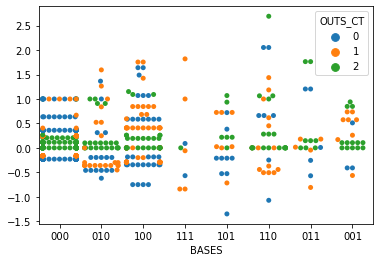

In [19]:
ax = sns.swarmplot(data=altuve, x="BASES", y="run_value", hue="OUTS_CT")
ax.set(ylabel="")

In [20]:
runs_altuve = altuve.groupby('BASES').agg(RUNS=('run_value', sum), PA=('run_value', 'count'))
runs_altuve

,RUNS,PA
BASES,,
000,18.913573,417
001,5.920250,24
010,4.179744,60
011,5.078014,18
100,19.796198,128
101,2.015682,22
110,13.349016,40
111,0.598479,8


In [21]:
runs_altuve.RUNS.sum()

69.8509554284813

In [22]:
data2016b = data2016.query('BAT_EVENT_FL=="T"')

In [23]:
runs = data2016b.groupby('BAT_ID').agg(RE24=('run_value', sum),
                                PA=('run_value', 'count'),
                                RUNS_START=('runs_state', sum))

runs.query('PA>=400')

,RE24,PA,RUNS_START
BAT_ID,,,
abrej003,62.234804,523,336.315363
alony001,29.290136,405,249.240831
altuj001,69.850955,563,346.261303
andre001,52.659524,431,256.657091
arenn001,81.110931,551,351.147332
...,...,...,...
vogts001,29.722927,410,244.985339
vottj001,82.186756,527,322.286687
wertj001,37.110136,484,293.731866
